Pruebas sobre el dataset 

In [285]:
%pip install rapidfuzz --quiet
%pip install spacy --quiet


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [92]:
%pip install wordcloud matplotlib --quiet


Note: you may need to restart the kernel to use updated packages.


In [93]:
import pandas as pd
import spacy
from collections import defaultdict
from pprint import pprint
import re
from unidecode import unidecode
from spacy.lang.es.stop_words import STOP_WORDS
import unicodedata
from wordcloud import WordCloud
import matplotlib.pyplot as plt


In [289]:
!python -m spacy download es_core_news_md --quiet


✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')


# Cargar Corpus y formatear fechas

In [3]:
file_path = r"C:\Users\karen\Documents\HumanidadesDigitales_git\BDD_Corpus\Corpus_completo_revisado.xlsx"
corpus_completo = pd.read_excel(file_path)


In [4]:
# Formatear fechas

meses = {
    'enero': '01',
    'febrero': '02',
    'marzo': '03',
    'abril': '04',
    'mayo': '05',
    'junio': '06',
    'julio': '07',
    'agosto': '08',
    'septiembre': '09',
    'octubre': '10',
    'noviembre': '11',
    'diciembre': '12'
}

def convertir_fecha(fecha_str):
    partes = fecha_str.split(' de ')
    dia = partes[0].zfill(2)  # Asegura 2 dígitos para días 1-9
    mes = meses[partes[1]]
    año = partes[2]
    return f"{dia}/{mes}/{año}"  # Formato DD/MM/AAAA

corpus_completo['Fecha'] = corpus_completo['Fecha'].apply(convertir_fecha)
corpus_completo['Fecha'] = pd.to_datetime(corpus_completo['Fecha'], format='%d/%m/%Y', errors='coerce')

In [5]:
corpus_completo.head()

,Diario,Autor,Fecha,Título,Texto,Vínculo,ID
0,El Espectador,Gonzalo Hernández,2018-01-01,Fajardo: para nada tibio,"La Coalición Colombia –Partido Alianza Verde, ...",https://web.archive.org/web/20180102104221/htt...,1
1,El Espectador,Eduardo Barajas Sandoval,2018-01-01,Macedonia de Norte,Las interpretaciones de la historia sirven com...,https://web.archive.org/web/20180102104221/htt...,2
2,El Espectador,Daniel Emilio Rojas Castro,2018-01-01,El nacionalismo según Vargas Llosa,La semana pasada Mario Vargas Llosa publicó un...,https://web.archive.org/web/20180102104221/htt...,3
3,El Espectador,Reinaldo Spitaletta,2018-01-01,"Tiempo sagrado, tiempo profano","Pudiera decirse, sin ser una verdad absoluta, ...",https://web.archive.org/web/20180102104221/htt...,4
4,El Espectador,Aura Lucía Mera,2018-01-01,La rebelión de los bueyes,Lo mejor del encierro de Las Ventas fueron los...,https://web.archive.org/web/20180102104221/htt...,5


In [ ]:
prueba = corpus_completo['Texto'].iloc[0].split('\n\n')

In [ ]:
from rapidfuzz import process, fuzz, utils


In [ ]:
process.extract_iter("sergio fajardo", prueba, scorer=fuzz.partial_ratio, processor=utils.default_process)

# Búsqueda exacta de  tesauros

In [6]:
textos = corpus_completo['Texto'].tolist()


In [7]:
nlp = spacy.load("es_core_news_md")

In [8]:
nlp.Defaults.stop_words |= {"tola","maruja","gazapera", "email protected"}

In [9]:
def preprocesar_texto(texto):
    # Limpieza
    texto = re.sub(r'http\S+|www\S+|https\S+', '', texto, flags=re.MULTILINE) # eliminar URLs
    texto = re.sub(r'\S+@\S+', '', texto) # eliminar correos electrónicos
    texto = re.sub(r'[^\w\sáéíóúñÁÉÍÓÚÑ]', ' ', texto) # mantener solo caracteres alfanuméricos y acentos
    
    # Procesamiento con spaCy tokenizacion
    doc = nlp(texto)
    
    # Lematización y filtrado
    tokens = [
        token.text for token in doc
        if not token.is_punct 
        and not token.is_stop
        and not token.is_space
        #and token.pos_ in ['NOUN', 'VERB', 'PROPN','ADJ', 'NUM']  # Tomar solo sustantivos, verbos, nombres propios, adjetivos y numerales
        and token.text.isalpha()  # Solo palabras alfabéticas
    ]
    
    return " ".join(tokens)
    

In [74]:
def limpieza(texto):

    
    texto = str(texto.lower())
    texto = re.sub(r'[\x00-\x1F\x7F-\x9F]', '', texto)
    texto = re.sub(r'http\S+|www\S+|https\S+', '', texto, flags=re.MULTILINE)  # Eliminar URLs
    texto = re.sub(r'\S+@\S+', '', texto) # eliminar correos electrónicos
    texto = re.sub(r'[^\w\sáéíóúñÁÉÍÓÚÑ]', ' ', texto) # mantener solo caracteres alfanuméricos y acentos
    texto = ''.join(c if c in 'ñÑ' else unicodedata.normalize('NFD', c)[0] for c in texto)
    #texto = texto.encode('ascii', 'ignore').decode('ascii')  # Solo ASCII
    texto = re.sub(r'\s+', ' ', texto).strip()  # Normalizar espacios
    
    return texto

textos_unicode = [limpieza(texto) for texto in textos]

In [75]:
diccionario_ciencia = ["ciencia", "cientifico", "investigación", "tecnología", "método científico", "descubrimiento", "experimentación", "análisis de datos", "hipótesis", "teoría científica"]

diccionario_ciencia = [limpieza(term) for term in diccionario_ciencia]

patron_busqueda = re.compile(r"\b(" + "|".join(diccionario_ciencia) + r")", flags=re.IGNORECASE)

diccionario_ciencia


['ciencia',
 'cientifico',
 'investigacion',
 'tecnologia',
 'metodo cientifico',
 'descubrimiento',
 'experimentacion',
 'analisis de datos',
 'hipotesis',
 'teoria cientifica']

In [86]:
def busqueda_palabras(textos, palabras_busqueda, ventana=5, ventana_stopwords=10):
    patron = re.compile(r"\b(" + "|".join(palabras_busqueda) + r")", re.IGNORECASE)
    resultados = []
    
    # Inicialmente pregunta si el texto contiene alguna palabra de búsqueda
    for i, texto in enumerate(textos):
        palabras_original = texto.split()

        # Buscar en texto (rápido)
        if patron.search(texto):
            # Buscar posiciones exactas en original
            for match in patron.finditer(texto):
                inicio, fin = match.span()
                
                # Convertir posición de caracteres a índice de palabra
                palabras_antes = texto[:inicio].split() # contar palabras antes de la coincidencia 
                palabra_idx = len(palabras_antes) - 1 if palabras_antes else 0
                
                contexto = " ".join(palabras_original[max(0, palabra_idx-ventana):min(palabra_idx+ventana+1, len(palabras_original)+1)])

                antes_sin_stopwords = [word for word in palabras_antes if (word.lower() not in STOP_WORDS)]
                antes_sin_stopwords = list(set(antes_sin_stopwords[-ventana_stopwords:]))  # limitar a ventana de stopwords
                despues_sin_stopwords = [word for word in palabras_original[palabra_idx+1:len(palabras_original)+1] if (word.lower() not in STOP_WORDS)]
                despues_sin_stopwords = list(set(despues_sin_stopwords[:ventana_stopwords]))  # limitar a ventana de stopwords
                
                resultados.append({
                    'texto_index': i,
                    'palabra': match.group(),
                    'posicion_caracter': (inicio, fin),
                    'posicion_palabra': palabra_idx,
                    'contexto': contexto,
                    'Antes_sin_stopwords': antes_sin_stopwords,
                    'Despues_sin_stopwords': despues_sin_stopwords,
                    'metadata': corpus_completo.iloc[i][['Título', 'Autor', 'Fecha', 'ID', 'Diario']].to_dict()
                })
    resultados_df = pd.DataFrame(resultados)

    return resultados_df

In [88]:
resultados = busqueda_palabras(textos_unicode, diccionario_ciencia, 10,10)
len(resultados)


6418

In [89]:
resultados.iloc[7].metadata

{'Título': 'Ovidio rehabilitado',
 'Autor': 'Ricardo Bada',
 'Fecha': Timestamp('2018-01-04 00:00:00'),
 'ID': 30,
 'Diario': 'El Espectador'}

In [91]:
resultados.iloc[7]

texto_index                                                             29
palabra                                                            ciencia
posicion_caracter                                               (596, 603)
posicion_palabra                                                       117
contexto                 que yo me convirtiera en mi libro no se sabe a...
Antes_sin_stopwords      [libro, licito, lugar, permitiesen, dioses, ve...
Despues_sin_stopwords    [destierro, ciencia, puerto, tomis, cayo, desg...
metadata                 {'Título': 'Ovidio rehabilitado', 'Autor': 'Ri...
Name: 7, dtype: object

In [105]:
resultados['Despues_sin_stopwords']

0       [javeriana, universidad, pontificia, investiga...
1       [gomez, escobar, buscara, pedi, espectador, pr...
2       [probo, magnicidio, condena, defender, materia...
3       [contraloria, republica, tiempo, procuraduria,...
4       [refiero, años, marcadas, nacido, cumple, conm...
                              ...                        
6413    [mayoria, exfuncionarios, fernanda, deberia, d...
6414    [quemas, monocultivos, provocan, incendios, ju...
6415    [prioridad, amazonia, culturas, internacional,...
6416    [parentesco, sufrimiento, cientificos, superio...
6417    [emproblemado, actos, pueblo, olvidado, placa,...
Name: Despues_sin_stopwords, Length: 6418, dtype: object

In [101]:
todas_las_palabras = []
for lista in resultados['Antes_sin_stopwords']:
    todas_las_palabras.extend(lista)

for lista in resultados['Despues_sin_stopwords']:
    todas_las_palabras.extend(lista)

palabras_contexto = ' '.join(todas_las_palabras)

In [102]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(palabras_contexto)

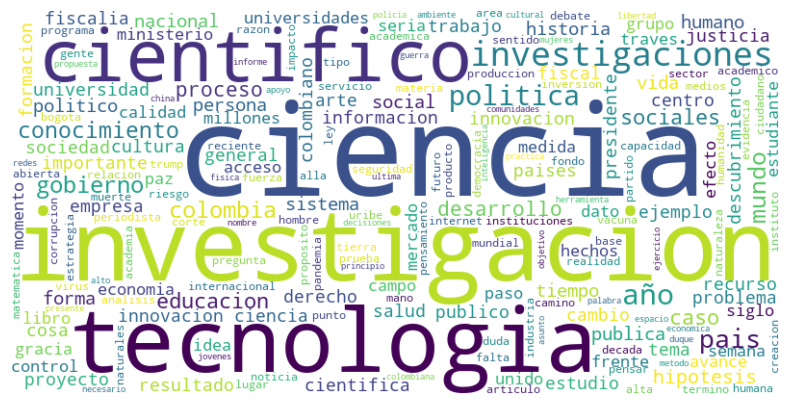

In [103]:
plt.figure(figsize=(10, 5)) # Ajusta el tamaño de la figura
plt.imshow(wordcloud, interpolation='bilinear') # Muestra la imagen de la nube de palabras
plt.axis('off') # Elimina los ejes
plt.show()

# Búsqueda semántica de tesauros